In [1]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
Tue Oct  3 14:21:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   48C    P0    70W / 275W |      3MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM... 

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[14:21:36.880] INFO   CaloQVAE                                          Willkommen!
[14:21:36.880] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[14:21:37.400] INFO   numexpr.utils                                     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[14:21:37.401] INFO   numexpr.utils                                     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[14:21:37.401] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2023-10-03 14:21:37,816 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[14:21:37.816] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [202]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [203]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[17:44:03.792] INFO   data.dataManager                                  Loading Data
[17:44:09.716] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fade9c30d90>: 80000 events, 157 batches
[17:44:09.717] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fad10386250>: 10000 events, 10 batches
[17:44:09.717] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fad885d4110>: 10000 events, 10 batches
[17:44:11.767] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasCRBMCNNDCond
2023-10-03 17:

40106 28512
Initializing NetworkV3


In [204]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[17:44:16.839] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[17:44:16.839] INFO   wandb                                             Watching
[17:44:16.842] INFO   engine.engineAtlas                                Setting up engine Atlas.
[17:44:16.842] INFO   engine.engineCaloV3                               Setting up engine Calo.
[17:44:16.843] INFO   engine.engine                                     Setting up default engine.


In [205]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[17:44:23.157] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fae4284aa90>: 80000 events, 157 batches
[17:44:23.157] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fad88593750>: 10000 events, 10 batches
[17:44:23.158] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fad103e8e10>: 10000 events, 10 batches


In [206]:
###LOAD MODEL

In [207]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [208]:

# generous-wave-3
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/13-46-23/wandb/run-20230822_134624-mn592vm0/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
modelname = 'generous-wave-3'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/13-46-23/wandb/run-20230822_134624-mn592vm0/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # faithful-sunset-4
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/17-51-11/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'faithful-sunset-4'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/17-51-11/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    

# lemon-water-5
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/18-36-38/wandb/run-20230822_183639-9adkmjtg/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'lemon-water-5'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/18-36-38/wandb/run-20230822_183639-9adkmjtg/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # atomic-glitter-6
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/19-39-35/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'atomic-glitter-6'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/19-39-35/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False


# fearless-plasma-9
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-23/13-58-19/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'fearless-plasma-9'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-23/13-58-19/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False

    
# flowing-serenity-11
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-23/14-41-33/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'fearless-plasma-9'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-23/14-41-33/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    

# vocal-lake-17
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-52-20/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'vocal-lake-17'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-52-20/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# clean-pyramid-18
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-53-30/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'clean-pyramid-18'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-53-30/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# charmed-donkey-40
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-11-54/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'clean-pyramid-18'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-11-54/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    # R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    R=0.002
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# earnest-dragon-28
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-28/16-57-14/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'earnest-dragon-28'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-28/16-57-14/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    # R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    R=0.002
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
# fluent-cherry-39
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-00-21/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'fluent-cherry-39'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-00-21/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    # R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    R=0.002
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
# # effortless-valley-50
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-30/12-55-16/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'effortless-valley-50'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-30/12-55-16/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # likely-sun-62
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-31/14-59-50/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# modelname = 'likely-sun-62'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-31/14-59-50/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # wild-terrain-65
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-31/18-38-18/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'wild-terrain-65'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-31/18-38-18/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # vague-cosmos-67
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-16-06/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# modelname = 'wild-terrain-65'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-16-06/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # cosmic-galaxy-68
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-44-21/wandb/latest-run/files/GumBoltCaloCRBM_atlas_default_best.pth"
# modelname = 'cosmic-galaxy-68'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-44-21/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # # sleek-sunset-71
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-01/17-51-57/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# # modelname = 'sleek-sunset-71'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-01/17-51-57/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False


# # revived-brook-81
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-04/00-39-34/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'revived-brook-81'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-04/00-39-34/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# # toasty-vortex-82
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-05/13-59-21/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'toasty-vortex-82'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-05/13-59-21/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
    
# # fearless-thunder-86
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-05-54/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'fearless-thunder-86'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-05-54/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
    
# # vocal-vortex-87
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-31-01/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'vocal-vortex-87'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-31-01/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # peachy-valley-83
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-05/14-19-17/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'peachy-valley-83'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-05/14-19-17/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
    
# # dulcet-wildflower-85
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-02-53/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'dulcet-wildflower-85'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-02-53/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


    
# # clear-sponge-88
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-37-06/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'clear-sponge-88'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-37-06/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# # efficient-field-94
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-10/21-46-16/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'clear-sponge-88'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-10/21-46-16/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
    
# # wandering-puddle-97
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'wandering-puddle-97'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # wandering-puddle-97
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'wandering-puddle-97'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # cerulean-thunder-98
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/17-21-33/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'cerulean-thunder-98'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/17-21-33/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # fluent-snowball-99
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/20-10-59/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'fluent-snowball-99'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/20-10-59/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # fluent-snowball-99
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-12/15-43-59/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# modelname = 'fluent-snowball-99'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-12/15-43-59/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     # R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# ruby-armadillo-178
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-42-59/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
modelname = 'ruby-armadillo-178'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-42-59/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True
    
    
# # fancy-dragon-180
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-26/13-56-27/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'fancy-dragon-180'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-26/13-56-27/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # # dainty-violet-177
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-37-50/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'dainty-violet-177'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-37-50/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # faithful-cherry-179
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-25/20-52-29/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'faithful-cherry-179'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-25/20-52-29/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False


# # eager-blaze-184
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-19-03/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'eager-blaze-184'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-19-03/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # expert-butterfly-182
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-26/16-53-25/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'expert-butterfly-182'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-26/16-53-25/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # likely-gorge-188
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-28/16-08-31/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'likely-gorge-188'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-28/16-08-31/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # colorful-plasma-183
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-02-15/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'colorful-plasma-183'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-02-15/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False

# royal-cosmos-197
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-30/15-03-45/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
modelname = 'royal-cosmos-197'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-30/15-03-45/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True
    
    
# # dashing-lion-194
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-29/15-56-19/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'dashing-lion-194'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-29/15-56-19/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True

# # vocal-salad-202
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-51-57/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'vocal-salad-202'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-51-57/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True

# # azure-resonance-201
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-47-14/wandb/latest-run/files/GumBoltCaloCRBM_atlas_default_best.pth"
# modelname = 'azure-resonance-201'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-47-14/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

GumBoltAtlasCRBMCNNDCond
electron-ds2
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
Loading weights for module =  sampler


In [209]:
xx = next(iter(train_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([512, 6480])


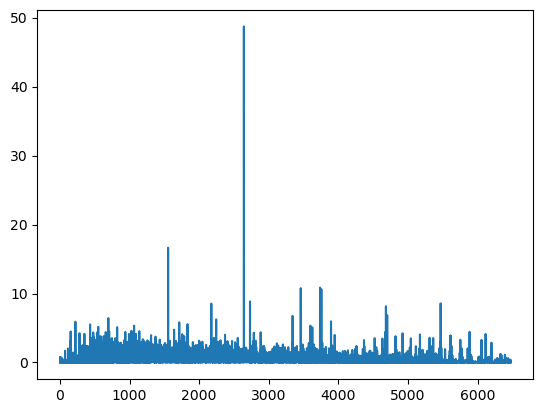

In [210]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

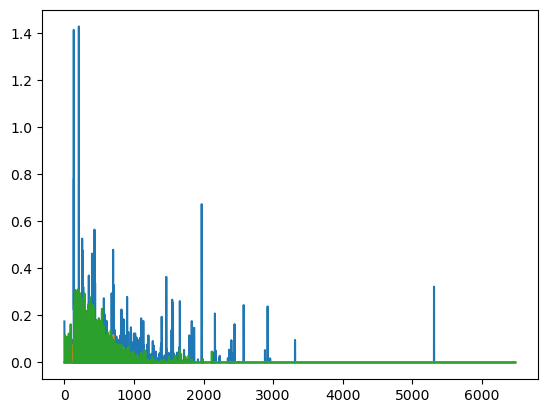

In [211]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    if reducedata:
        in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 10
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:])
plt.plot(sample_data.detach().cpu().numpy()[idx,:])

In [213]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
# plt.plot(post_samples[0][0,:].detach().cpu().numpy())
# post_samples = torch.cat(post_samples, 1)

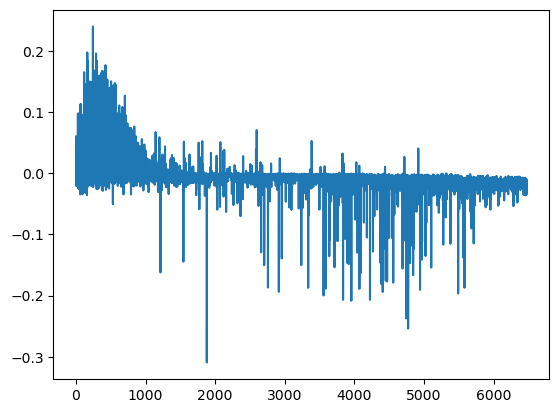

In [214]:
# post_samples = torch.cat([post_samples, true_energy], dim=1)
post_samples = torch.cat(post_samples,1)
# output_hits, output_activations = engine.model.decoder(post_samples)
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


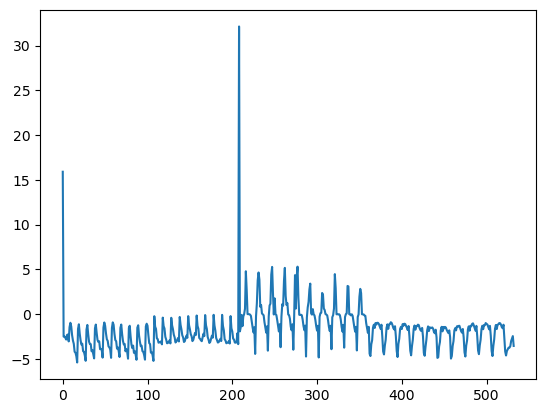

In [26]:
# self._hit_smoothing_dist_mod(output_hits, beta, is_training)
plt.plot(output_hits[1,:].detach().cpu().numpy())
beta = torch.tensor(5, dtype=torch.float, device=output_hits.device, requires_grad=False)

In [68]:
beta = torch.tensor(1, dtype=torch.float, device=output_hits.device, requires_grad=False)

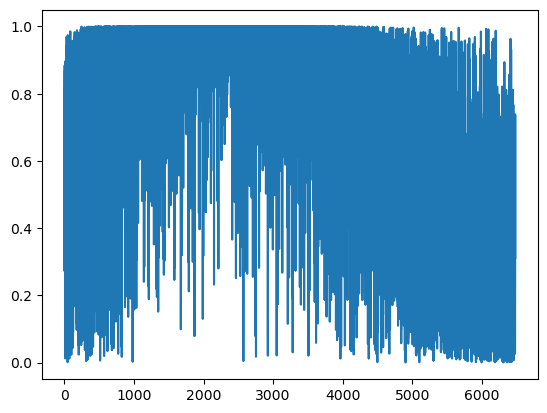

In [69]:
plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, beta, True)[2,:].detach().cpu().numpy())

In [20]:
# for i in range(1,100):
#     print(533 % i, i, 533/i)

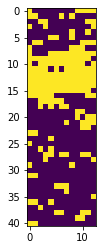

In [30]:
# engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu()
idx=5
# plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(23,16))
plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(41,13))

In [239]:
(output_hits.sum(dim=0) == 0).sum()
engine._config.model.output_smoothing_fct

# engine.model._energy_activation_fct
beta = torch.tensor(engine._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)
output = engine.model._energy_activation_fct(output_activations) * engine.model._hit_smoothing_dist_mod(output_hits, beta, False)
o1 = engine.model._energy_activation_fct(output_activations)
o2 = engine.model._hit_smoothing_dist_mod(output_hits, beta, False)

In [242]:
(output.sum(dim=0) == 0).sum()
(o1.sum(dim=0) == 0).sum()
(o2.sum(dim=0) == 0).sum()
# (in_data.sum(dim=0) == 0).sum()
# in_data.shape
engine.model._energy_activation_fct

ReLU()

In [241]:
# true_energy
# rbm_vis.device
engine._model.decoder

DecoderCNNCondSmall(
  (_layers): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(2000, 1, 1))
    (1): ConvTranspose2d(2000, 512, kernel_size=(4, 4), stride=(2, 2))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=512)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): PReLU(num_parameters=256)
  )
  (_activation_fct): ReLU()
  (_layers2): Sequential(
    (0): ConvTranspose2d(257, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
    (3): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_feature

In [192]:
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    if reducedata:
        in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), False)
    if reducedata:
        in_data = engine._reduceinv(in_data, true_energy, R=R)
        recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
        engine._model.sampler._batch_size = true_energy.shape[0]
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
    elif scaled:
        in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
        recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
        engine._model.sampler._batch_size = true_energy.shape[0]
        # try:
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
        # except:
            # pass
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
        sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))

    # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
#     if engine._config.engine.cl_lambda:
#         labelsrecon_samples.append(fwd_output.labels.detach().cpu())
#         labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )
    
#         en_labels.append(true_energy.detach().cpu())
    
    xtarget_samples.append(in_data.detach().cpu())
    xrecon_samples.append( recon_data.detach().cpu())
    xgen_samples.append( sample_data.detach().cpu())
    entarget_samples.append(true_energy.detach().cpu())
    
    # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# if engine._config.engine.cl_lambda:
#     labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
#     labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
#     en_labels = torch.cat(en_labels, dim=0)

#     lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
#     l = torch.argmax(labelstarget_samples, dim=1).numpy()


In [193]:
(xgen_samples.sum(dim=0) == 0).sum()
(xrecon_samples.sum(dim=0) == 0).sum()
# (xtarget_samples.sum(dim=0) == 0).sum()
# print((xgen_samples.sum(dim=0) == 0).nonzero(as_tuple=True))
# print((xrecon_samples.sum(dim=0) == 0).nonzero(as_tuple=True))

tensor(2826)

gen
0


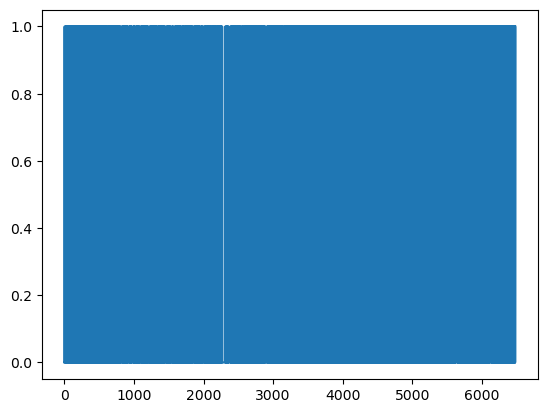

In [122]:

# # (xrecon_samples.sum(dim=1) == 0)[0].item()
# for i, iszero in enumerate(xrecon_samples.sum(dim=0) == 0):
#     if iszero:
#         print(i)
# print("gen")        
# for i, iszero in enumerate(xgen_samples.sum(dim=0) == 0):
#     if iszero:
#         print(i)

l1 = 0
for i, iszero in enumerate(xtarget_samples.sum(dim=0) == 0):
    if iszero:
        # print(i)
        l1 +=1

l2 = []
for i, iszero in enumerate(xrecon_samples.sum(dim=0) == 0):
    if iszero:
        # print(i)
        # l2 +=1
        l2.append(1)
    else:
        l2.append(0)
print("gen") 
l3 = []
for i, iszero in enumerate(xgen_samples.sum(dim=0) == 0):
    if iszero:
        # l3+=1
        l3.append(1)
    else:
        l3.append(0)
    
print(l1)
plt.plot(l2)
# plt.plot(l3)
plt.show()

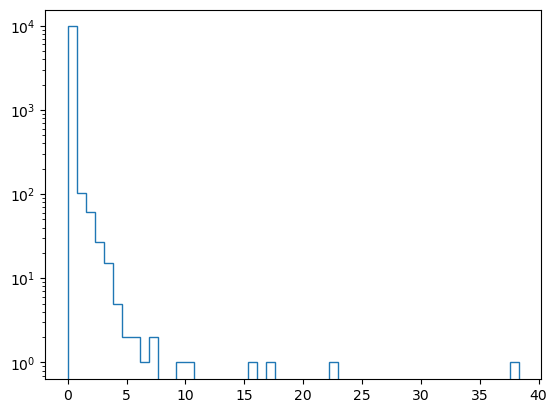

In [44]:
idx = 1
plt.hist(xrecon_samples[:,idx], bins=50, log=True, histtype='step')
plt.show()

In [154]:
xtarget_samples.shape[1]

6480

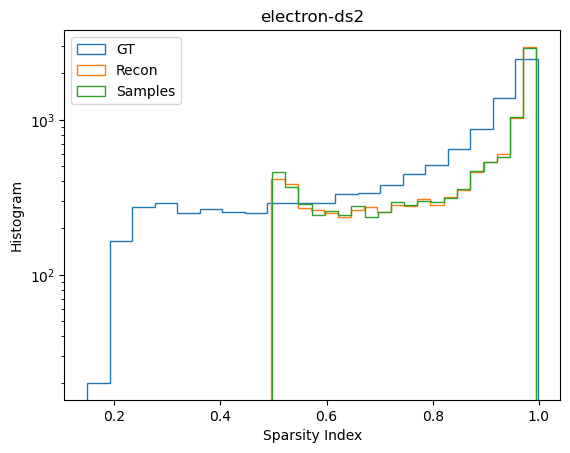

In [194]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step')
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step')
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step')
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples"])
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [600]:
# np.exp(8)
# torch.abs(torch.sign(engine.model.sampler._RBM.weights))[:10,:10]

In [601]:
# plt.hist(engine.model.sampler._RBM.visible_bias.detach().cpu().numpy())
# plt.hist(engine.model.sampler._RBM.hidden_bias.detach().cpu().numpy())
# plt.hist(engine.model.sampler._RBM.weights.detach().cpu().numpy().reshape(500*500))
# plt.show()
# plt.plot(engine.model.sampler._RBM.weights.detach().cpu().numpy().reshape(500*500))


Layer  0 8  voxels


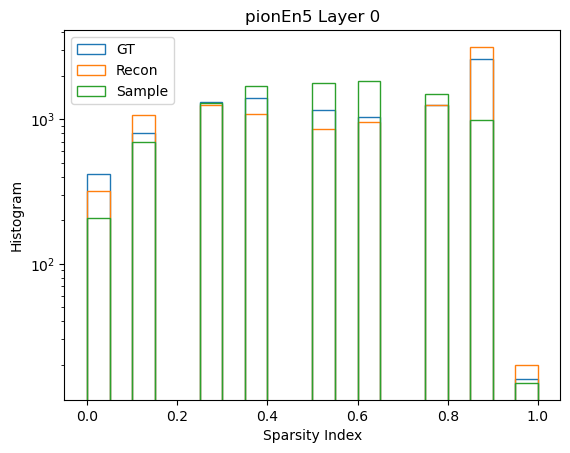

Layer  1 100  voxels


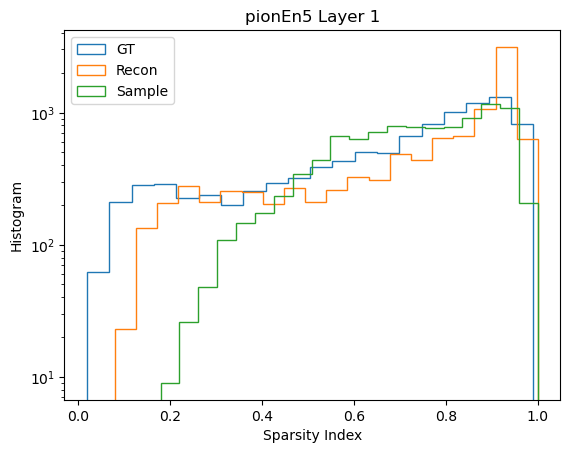

Layer  2 100  voxels


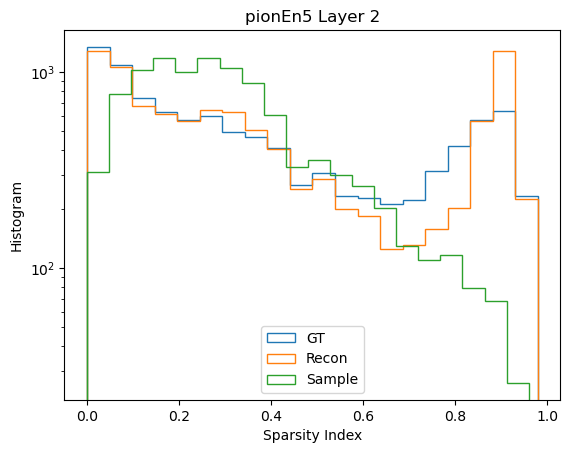

Layer  3 5  voxels


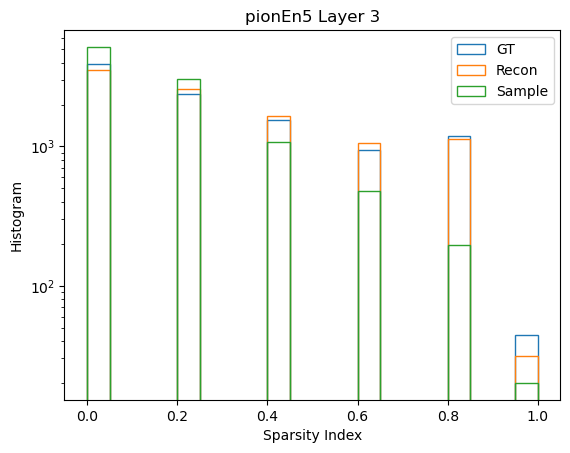

Layer  4 150  voxels


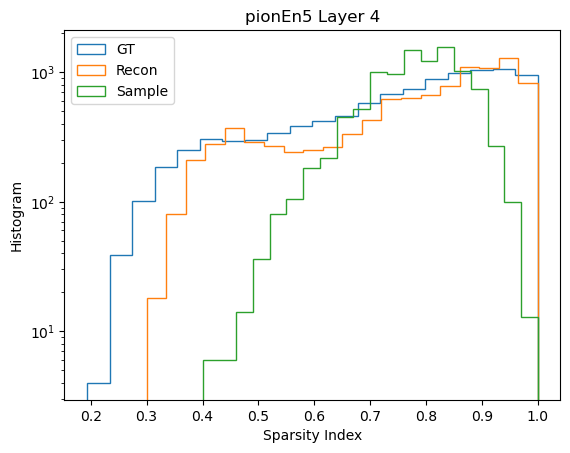

Layer  5 160  voxels


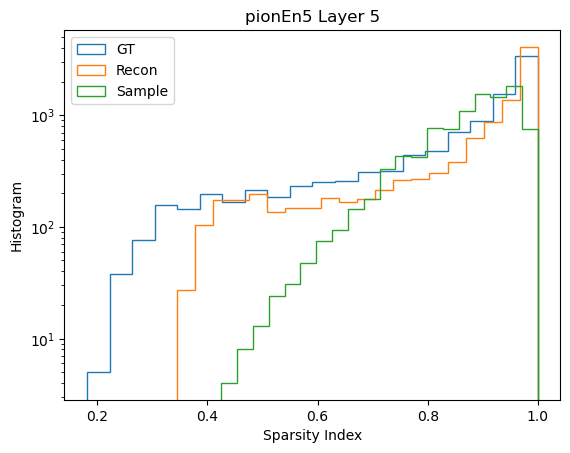

Layer  6 10  voxels


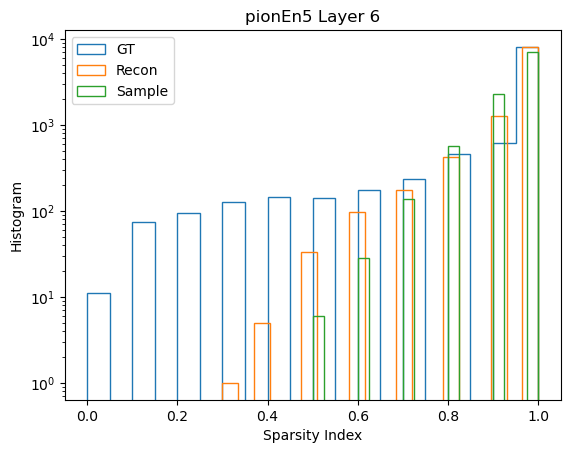

In [111]:
idxPrev = 0
for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(1,5)]):
# for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
    plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
    plt.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
    plt.xlabel("Sparsity Index")
    plt.ylabel("Histogram")
    plt.legend(["GT", "Recon", "Sample"])
    plt.title(f'{part} Layer {i}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

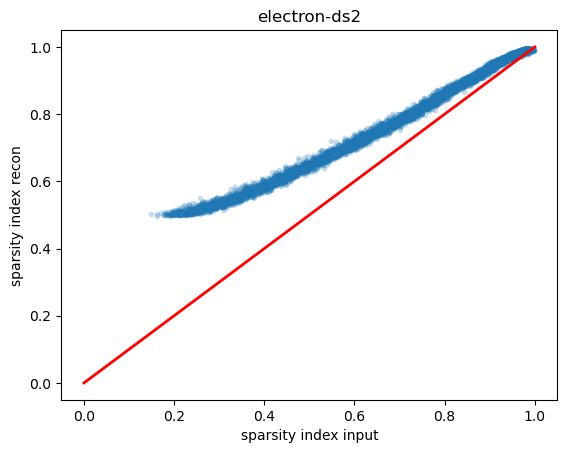

In [195]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.2)
plt.plot([0,1],[0,1], c='red', lw=2)
plt.xlabel('sparsity index input')
plt.ylabel('sparsity index recon')
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

Layer  0 8  voxels


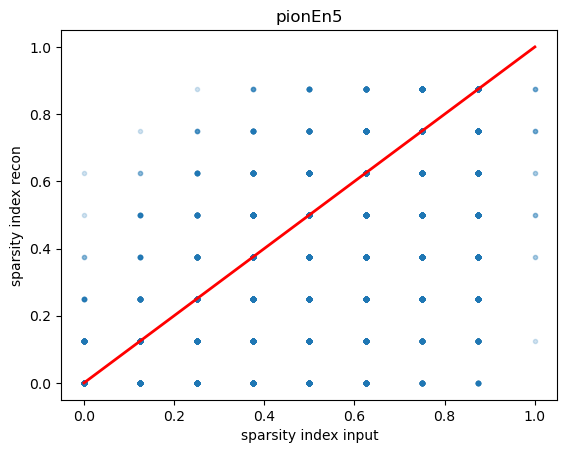

Layer  1 100  voxels


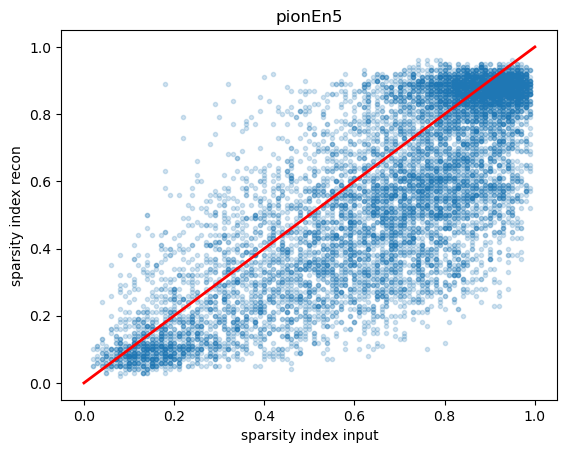

Layer  2 100  voxels


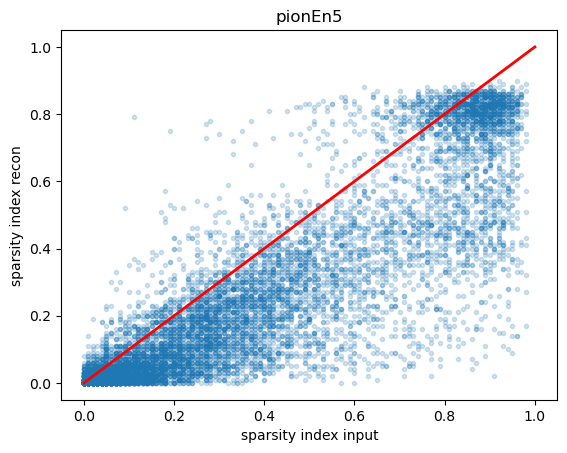

Layer  3 5  voxels


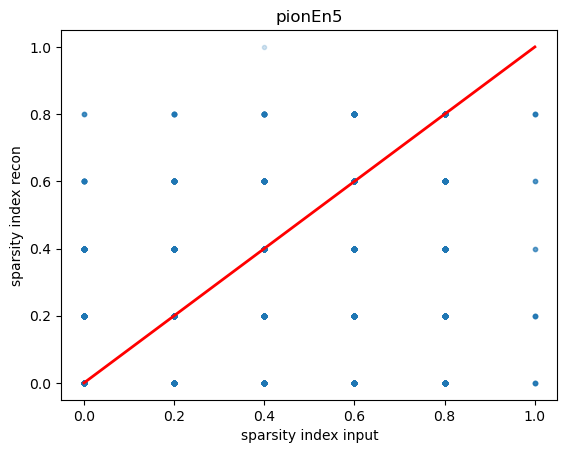

Layer  4 150  voxels


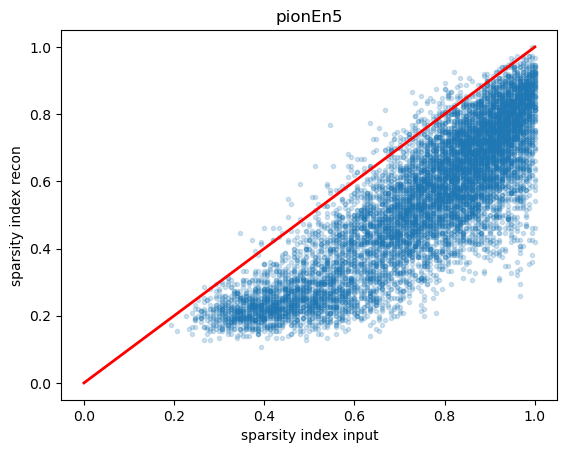

Layer  5 160  voxels


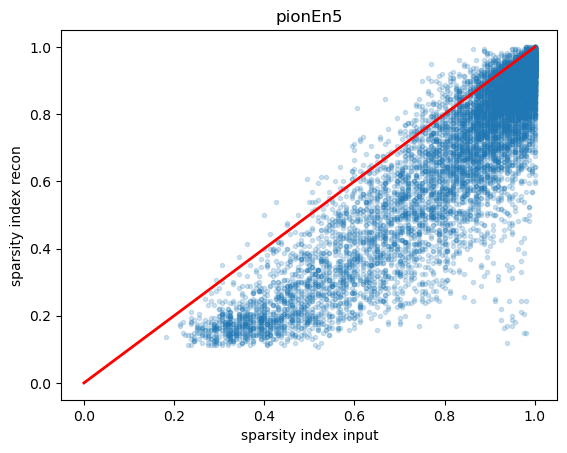

Layer  6 10  voxels


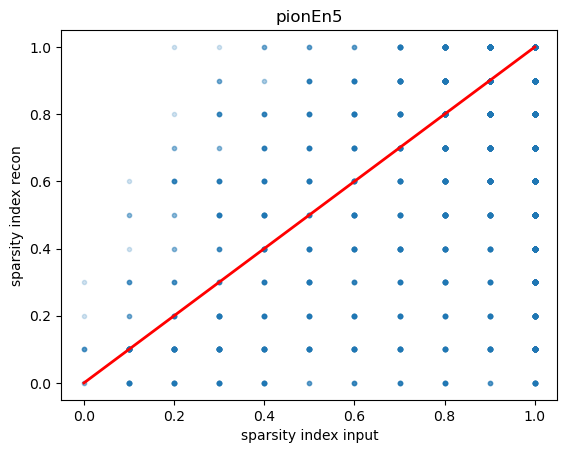

In [173]:
idxPrev = 0
for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.scatter(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), marker='.', alpha=.2)
    plt.plot([0,1],[0,1], c='red', lw=2)
    plt.xlabel('sparsity index input')
    plt.ylabel('sparsity index recon')
    plt.title(f'{part}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

In [401]:
# xihat_samples.shape
np.unique(HLF_1_photons.bin_edges)

array([  0,   8, 168, 358, 363, 368])

In [196]:
tmp = (entarget_samples < 15500) * (entarget_samples > 10000)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
len(idxEnFilter)

636

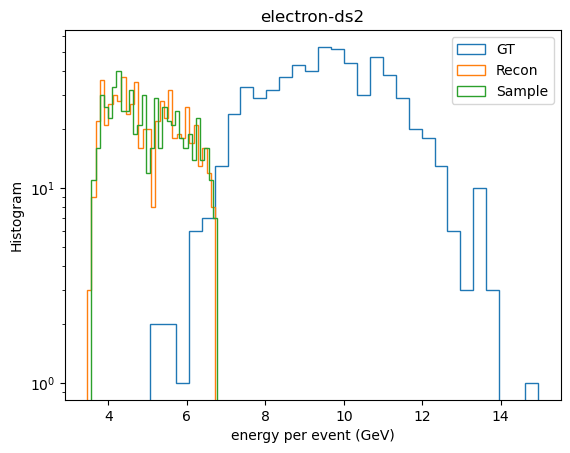

In [197]:
plt.hist(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step')
plt.hist(xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step')
plt.hist(xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step')

plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample"])
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

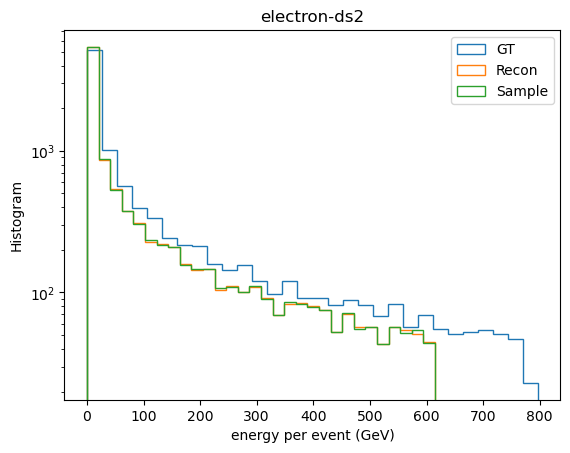

In [198]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step')
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step')
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step')
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample"])
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

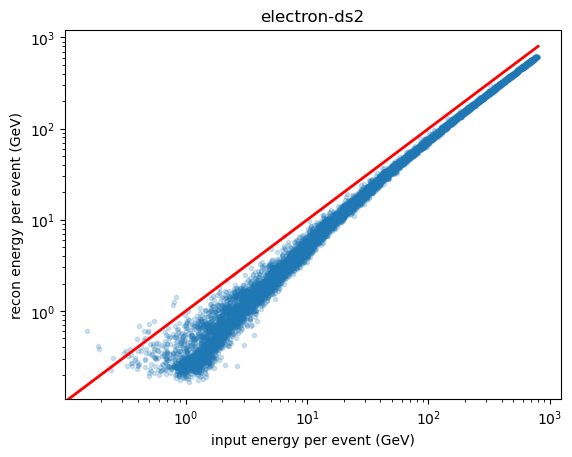

In [199]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.2)
plt.plot([0,800],[0,800], c='red', lw=2)
# plt.plot([0,20],[0,20], c='red', lw=2)

# sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),0)
# plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("input energy per event (GeV)")
plt.ylabel("recon energy per event (GeV)")
plt.title(f'{part}')
plt.yscale('log')
plt.xscale('log')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

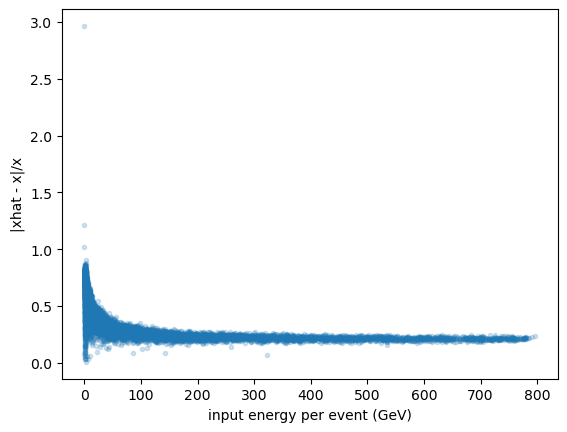

In [200]:
# plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xtarget_samples.sum(dim=1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.2)
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/xtarget_samples.sum(dim=1).numpy(), marker='.', alpha=.2)
# plt.xscale('log')
plt.xlabel("input energy per event (GeV)")
plt.ylabel("|xhat - x|/x")
plt.show()

In [47]:
# plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.hist(xihat_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.xlabel("ξ per event")
# plt.ylabel("PDF")
# plt.legend(["GT", "Recon", "Sample"])
# plt.title("Pions")
# plt.show()
# [16*9*i for i in range(1,46)]

Layer  0 144  voxels


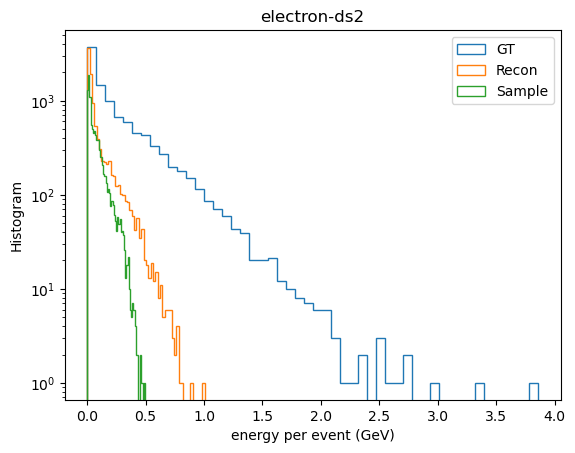

Layer  1 144  voxels


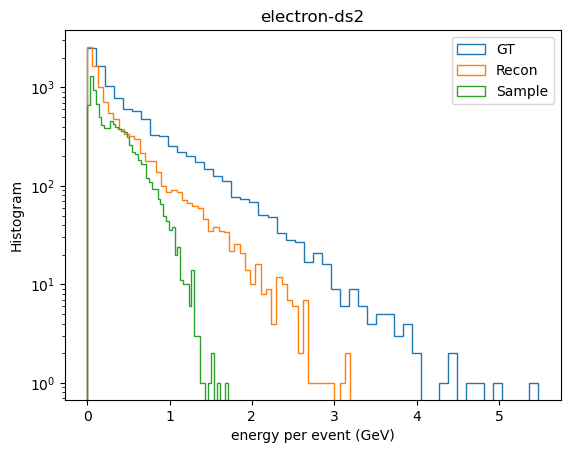

Layer  2 144  voxels


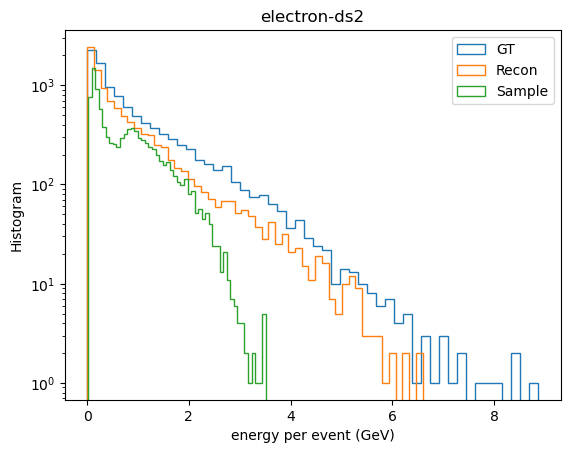

Layer  3 144  voxels


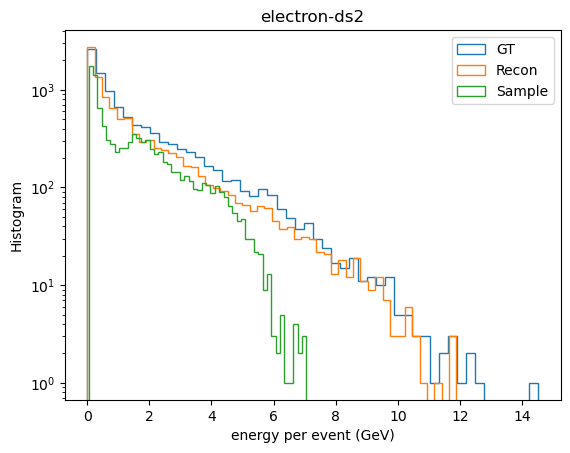

Layer  4 144  voxels


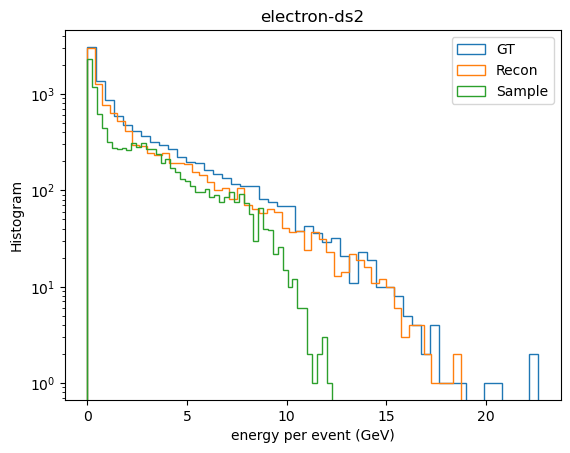

Layer  5 144  voxels


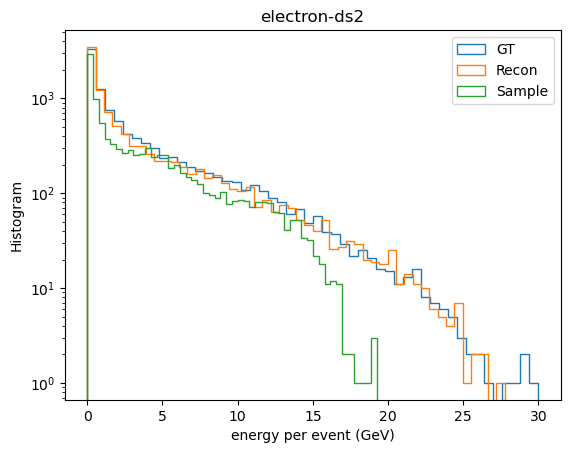

Layer  6 144  voxels


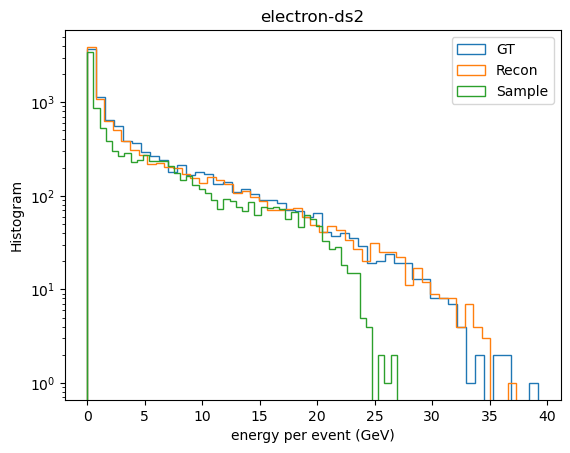

Layer  7 144  voxels


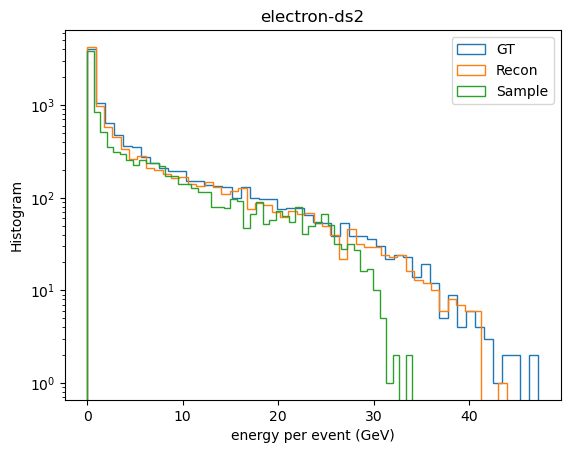

Layer  8 144  voxels


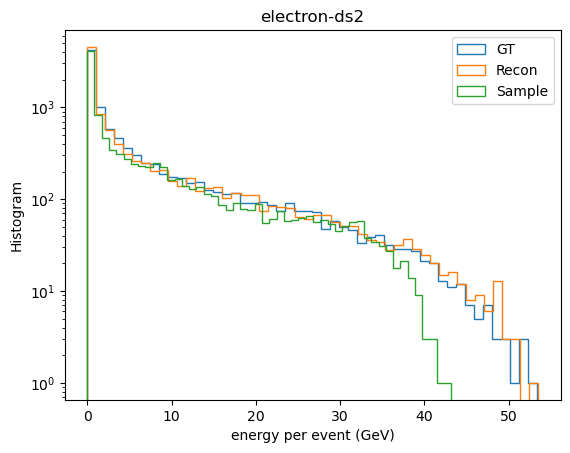

Layer  9 144  voxels


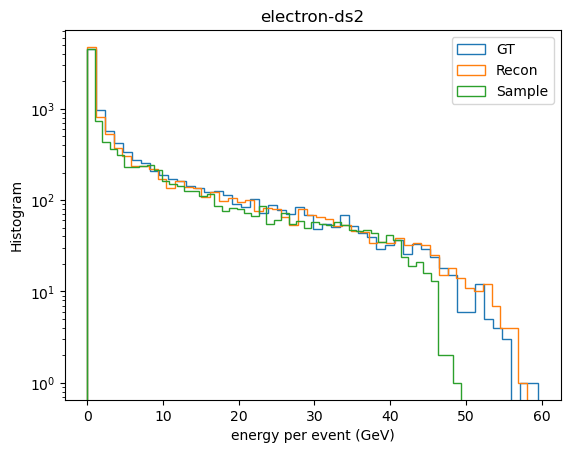

Layer  10 144  voxels


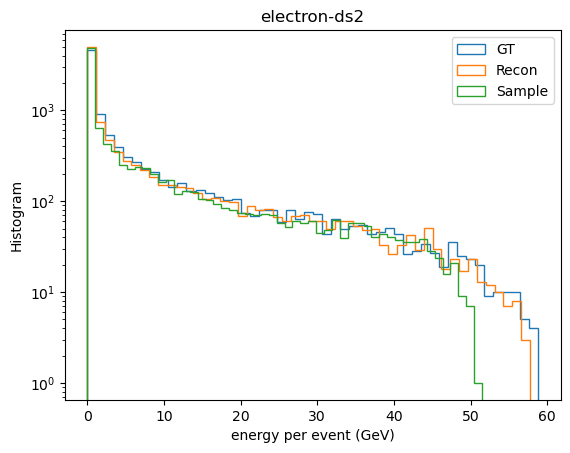

Layer  11 144  voxels


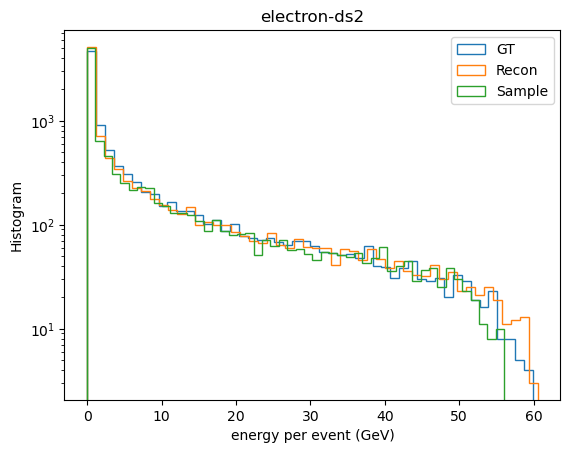

Layer  12 144  voxels


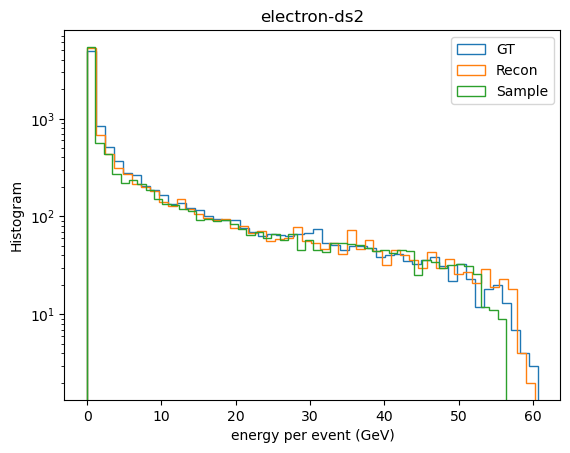

Layer  13 144  voxels


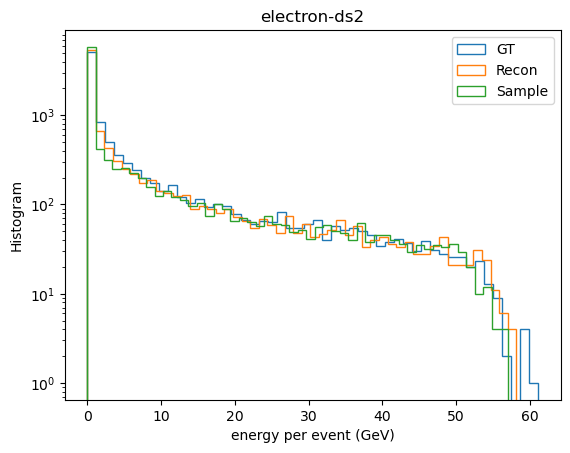

Layer  14 144  voxels


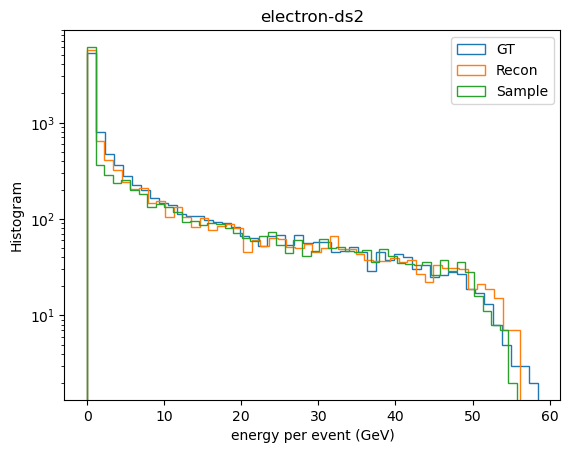

Layer  15 144  voxels


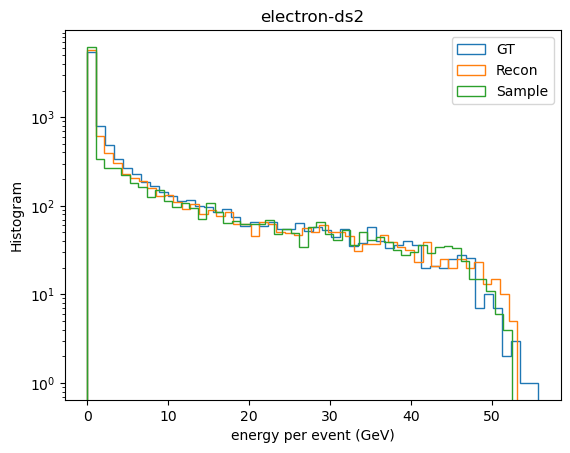

Layer  16 144  voxels


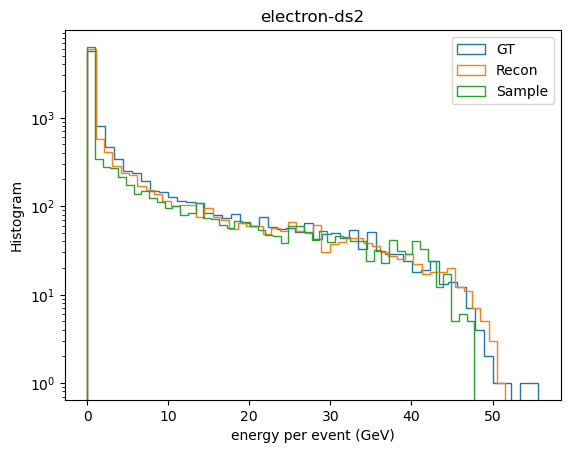

Layer  17 144  voxels


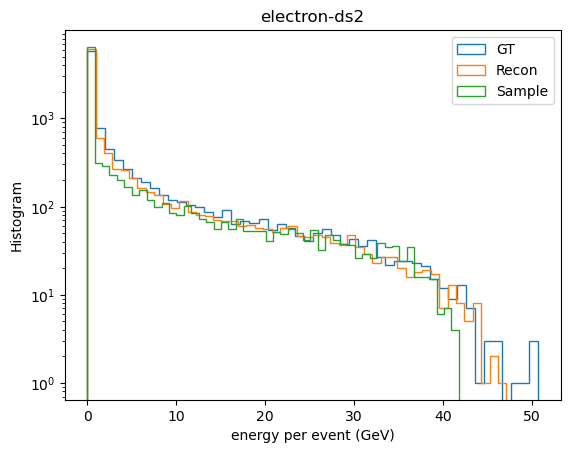

Layer  18 144  voxels


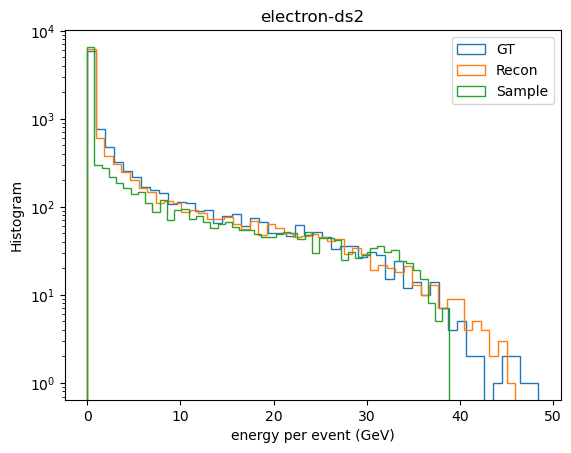

In [24]:
idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate([16*9*i for i in range(1,20)]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    # plt.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
    # plt.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
    # plt.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
    plt.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.xlabel("energy per event (GeV)")
    plt.ylabel("Histogram")
    plt.legend(["GT", "Recon", "Sample"])
    plt.title(f'{part}')
    # # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

Layer  0 1440  voxels


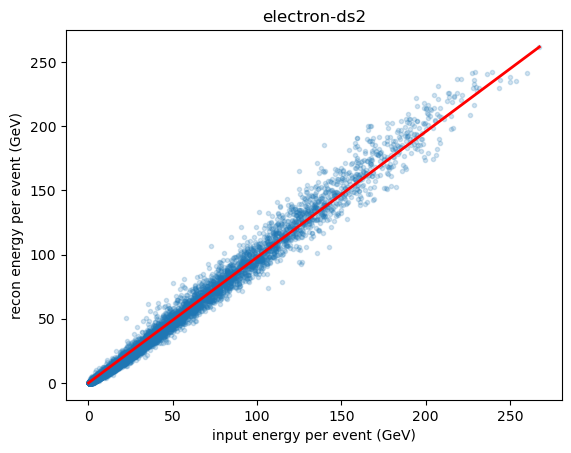

Layer  1 144  voxels


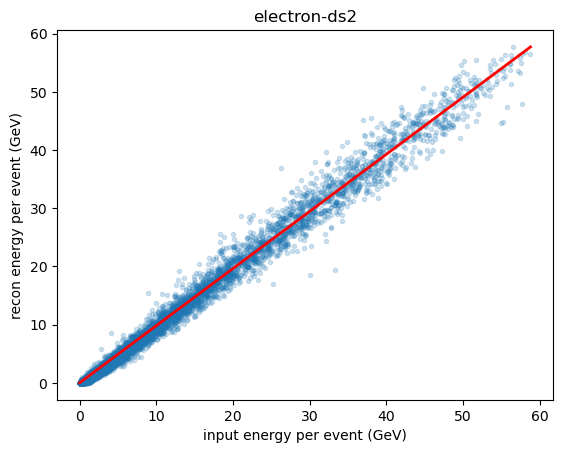

Layer  2 144  voxels


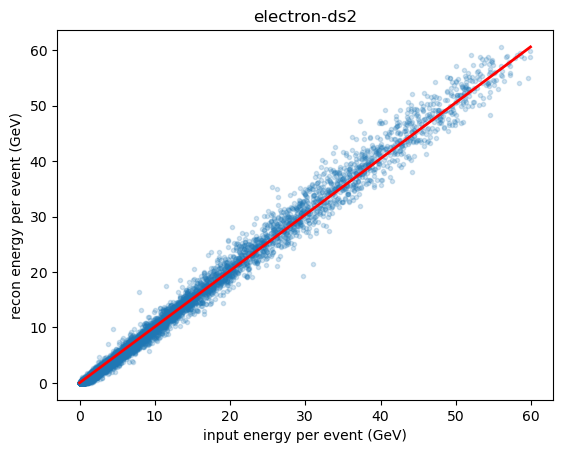

Layer  3 144  voxels


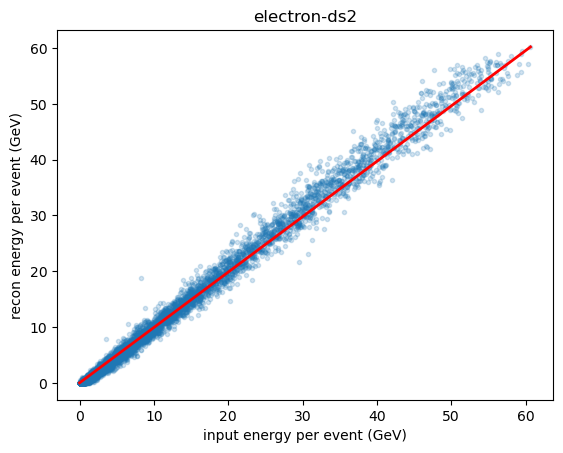

Layer  4 144  voxels


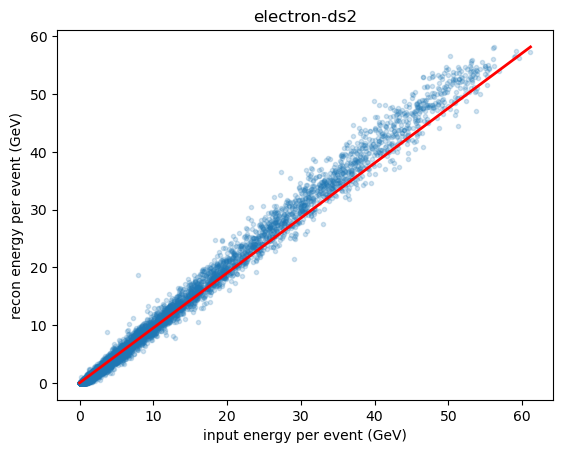

Layer  5 144  voxels


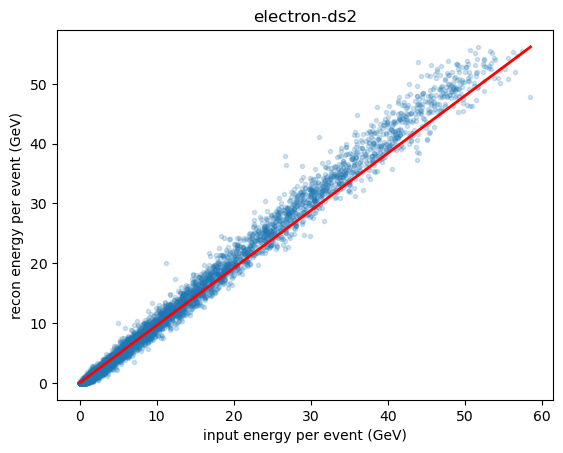

Layer  6 144  voxels


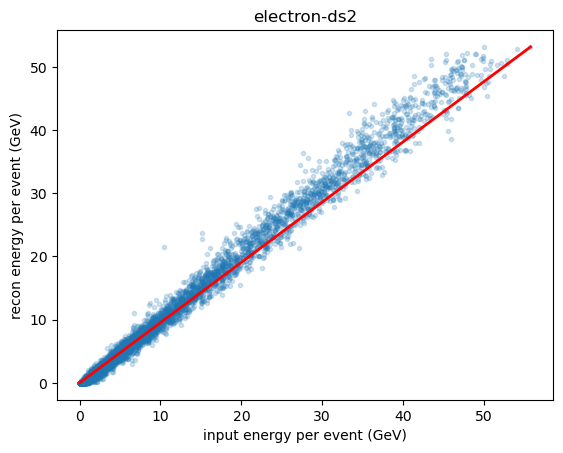

Layer  7 144  voxels


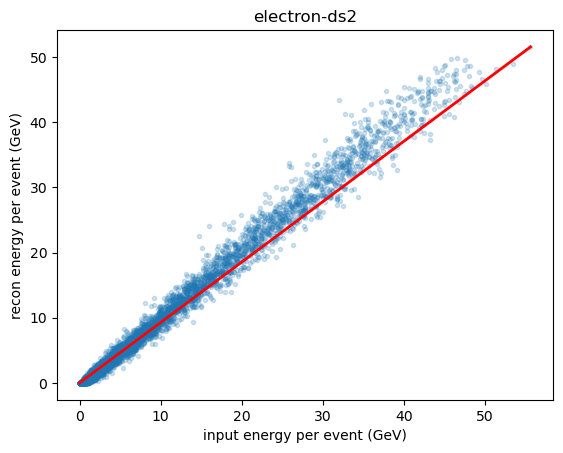

Layer  8 144  voxels


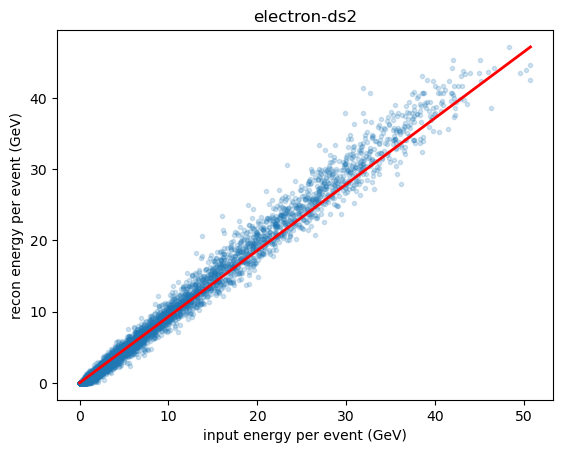

Layer  9 144  voxels


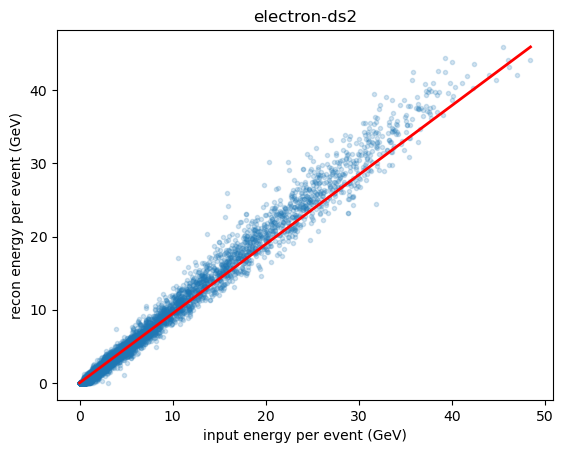

In [25]:
idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate([16*9*i for i in range(10,20)]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.scatter(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, marker='.', alpha=.2)
    plt.plot([0,xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000],[0,xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000], c='red', lw=2)
    
    plt.xlabel("input energy per event (GeV)")
    plt.ylabel("recon energy per event (GeV)")
    plt.title(f'{part}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

In [151]:
np.unique(HLF_1_pions.bin_edges)

array([  0,   8, 108, 208, 213, 363, 523, 533])

In [60]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [76]:
if reducedata:
    in_data = engine._reduce(in_data, true_energy, R=R)
fwd_output = engine.model((in_data, true_energy), False)
if reducedata:
    in_data = engine._reduceinv(in_data, true_energy, R=R)
    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
elif scaled:
    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
    engine._model.sampler._batch_size = true_energy.shape[0]
    # try:
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    # except:
        # pass
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))

In [62]:
HLF_1_pions.relevantLayers = [1,2,3,4,5,6,7]

In [26]:
HLF_1_electron.relevantLayers = [5,10,15,30,35]

In [27]:
# (((in_data[:,0:108] - recon_data[:,0:108])/(in_data[:,0:108]))**2).sum(dim=1).argsort()[:20]
(((in_data - recon_data)/(in_data+1e-5))**2).sum(dim=1).argsort()[-10:-1]
# (((in_data - recon_data))**2).sum(dim=1).argsort()[:20]

tensor([781,  98, 238, 195, 719, 728,  25, 274, 219])

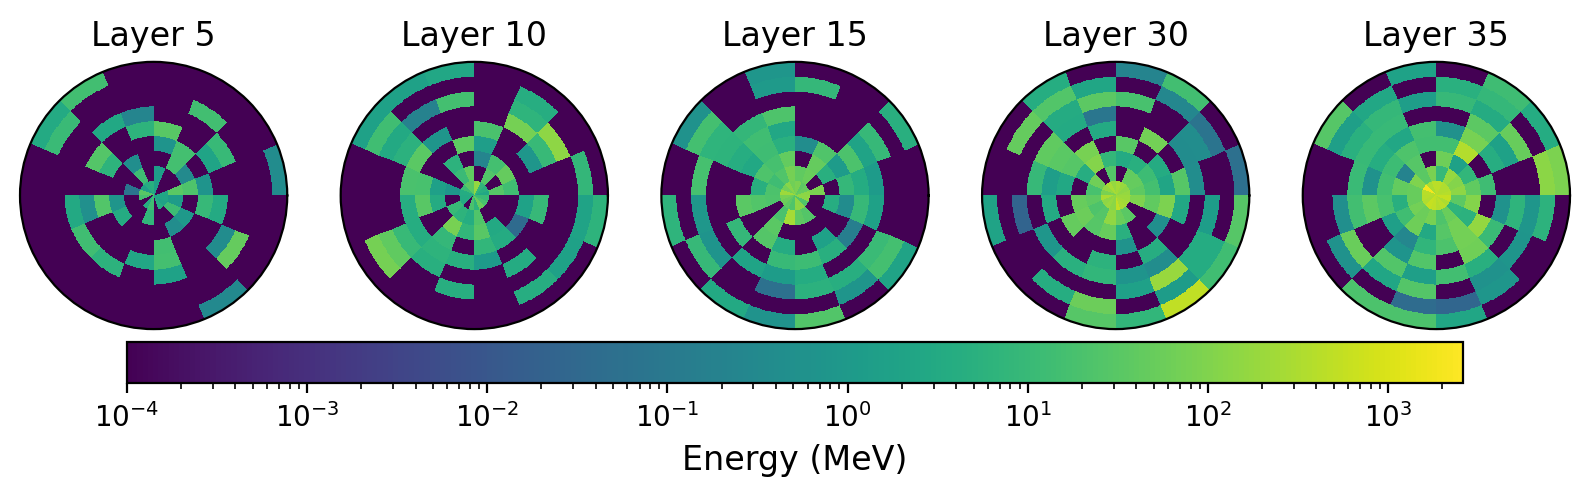

In [28]:
idx=781
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)

# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), 
                             # filename=f'/home/javier/Projects/CaloQVAE/figs/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), 
#                                 filename=f'/home/javier/Projects/CaloQVAE/figs/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), 
                                filename=None)


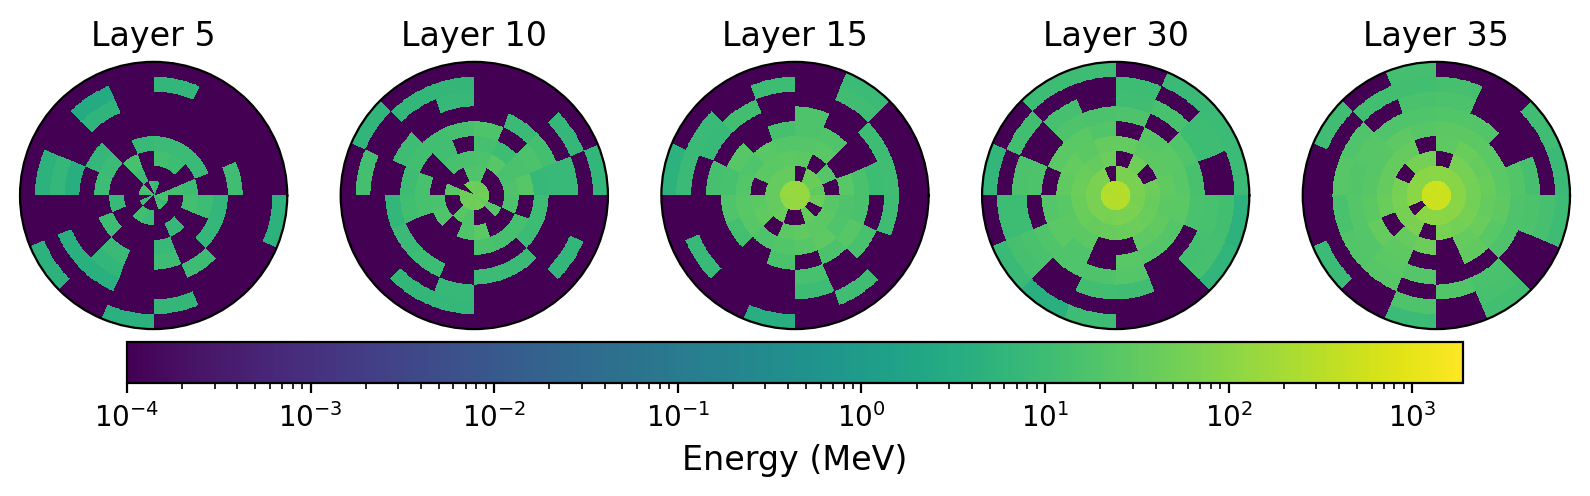

In [29]:
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), 
#                              filename=f'/home/javier/Projects/CaloQVAE/figs/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), 
#                                 filename=f'/home/javier/Projects/CaloQVAE/figs/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), 
                                filename=None)


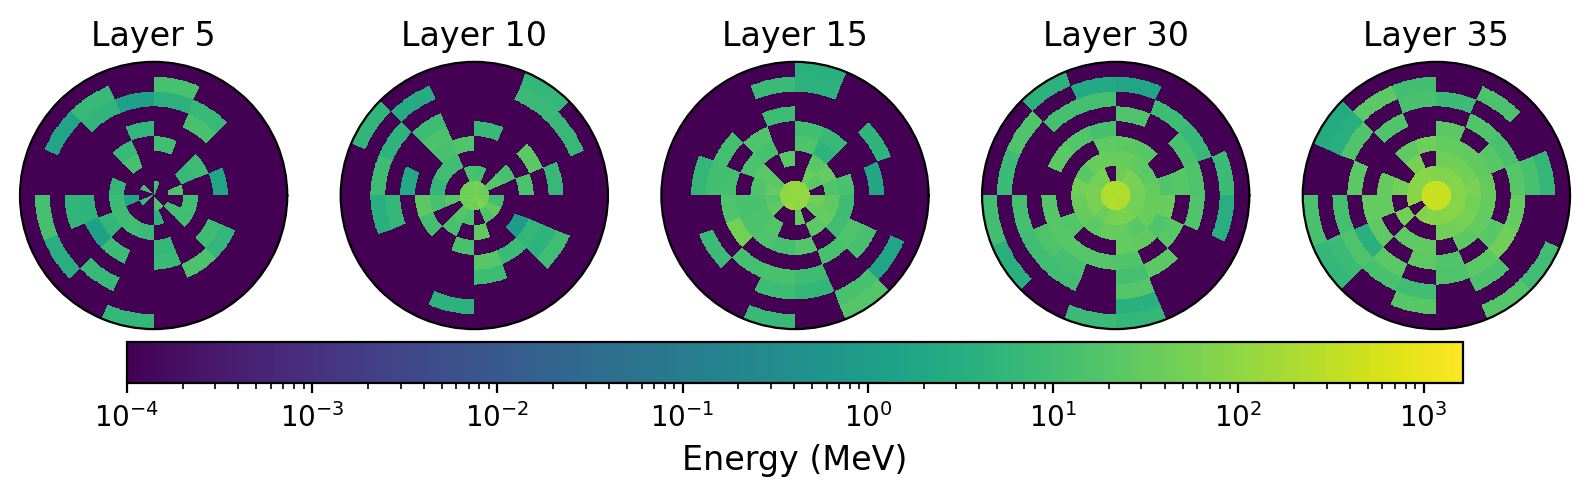

In [30]:
# HLF_1_pions.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawAverageShower(in_data[idx:idx+10,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), 
#                              filename=f'/home/javier/Projects/CaloQVAE/figs/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), 
                             # filename=f'/home/javier/Projects/CaloQVAE/figs/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), 
                             filename=None)

In [ ]:
# Gen synth data

In [51]:
import h5py

In [52]:
ef = h5py.File('/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/dataset_2_1.hdf5', 'r')

In [54]:
ef["showers"]

<HDF5 dataset "showers": shape (100000, 6480), type "<f8">

(array([684.,  89.,  70.,  45.,  40.,  29.,  21.,  19.,  14.,  13.]),
 array([  1.01109469, 100.08539581, 199.15969849, 298.23397827,
        397.30828857, 496.38259888, 595.45690918, 694.53118896,
        793.60546875, 892.67980957, 991.75408936]),
 <BarContainer object of 10 artists>)

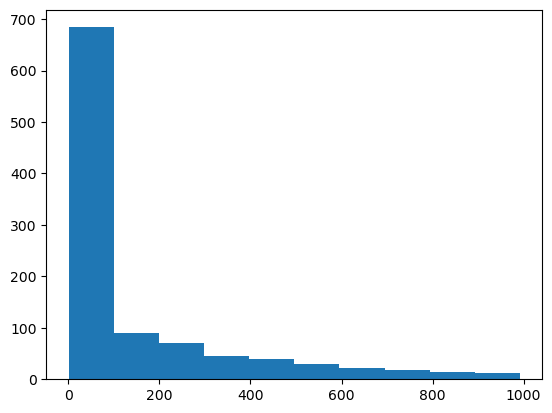

In [57]:
plt.hist(true_energy.detach().cpu().numpy()/1000)

In [62]:
in_data.sum(dim=1)

tensor([  2251.5442,   2548.4956, 197991.8125,  ...,   1088.8044,
         83722.3125,  28762.7969])

In [63]:
true_energy

tensor([[  2128.1135],
        [  3865.5706],
        [256267.9375],
        ...,
        [  1324.8855],
        [110361.2812],
        [ 35360.6562]], device='cuda:0')